In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
from glob import glob as glob
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
gsname = 'gs0122'

### load data

In [3]:
# ## run make_df-1102.py to make dfs
# datadf = datadf1 = pd.read_csv('data/%s-datadf-1.csv'%gsname)
datadf = datadf1 = pd.read_csv('data/%s-datadf-0.csv'%gsname)


In [4]:
gsdf = pd.read_csv('data/%s-summdf.csv'%gsname).astype(float)
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,testacc-b,acc2-b,testacc-e,acc2-e,testacc-i,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m
0,0.0,0.452654,6.474396,20.705067,0.007842,0.0,1.0,0.173007,0.999177,1.0,0.981986,0.957713,0.981986,0.957713,0.981986,0.981929,0.981986,0.981930,0.981986,0.981947
1,0.0,1.956960,81.757547,69.478174,0.017013,0.0,1.0,0.583418,0.974830,1.0,0.981623,0.957230,0.981625,0.957230,0.581460,0.552131,0.564330,0.538546,0.598277,0.750655
2,0.0,3.142684,31.030939,51.950197,0.059351,0.0,1.0,0.728323,0.970286,1.0,0.980352,0.955248,0.980358,0.955242,0.580186,0.546676,0.608997,0.572522,0.582803,0.709357
3,0.0,1.436382,38.243563,47.459777,0.007203,0.0,1.0,0.300087,0.988197,1.0,0.981936,0.957689,0.981936,0.957689,0.981936,0.981893,0.981936,0.981894,0.981936,0.981908
4,0.0,0.200397,92.581127,31.593803,0.001262,0.0,1.0,0.358018,0.980330,1.0,0.981991,0.957868,0.981992,0.957868,0.981992,0.981986,0.981991,0.981986,0.981992,0.981988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,0.0,3.392765,9.231325,90.977964,0.017857,0.0,1.0,0.928437,0.981047,1.0,0.981709,0.957275,0.981710,0.957275,0.981710,0.981629,0.981708,0.981627,0.981707,0.981659
770,0.0,3.432209,56.446387,33.489331,0.020232,0.0,1.0,0.783566,0.969229,1.0,0.981432,0.957012,0.981434,0.957015,0.981434,0.981379,0.981435,0.981378,0.981435,0.981401
771,0.0,0.491067,72.992633,6.663479,0.008178,0.0,1.0,0.515680,0.991826,1.0,0.981948,0.957675,0.981948,0.957675,0.981948,0.981894,0.981948,0.981894,0.981949,0.981912
772,0.0,2.298293,42.744926,43.145055,0.015799,0.0,1.0,0.887451,0.972051,1.0,0.981605,0.957249,0.981606,0.957248,0.981606,0.981559,0.981608,0.981562,0.981607,0.981579


In [5]:
## human data
hdf = pd.read_csv('../human_data.csv')
humanD = {}
for c in ['blocked','interleaved','early','middle','late']:
  humanD[c[0]] = hdf.loc[:,('%s mean')%c].values.T[-40:].mean()
## difference to human
for c in ['b','i','e','m','l']:
  gsdf['%s-test_diff'%c] = np.abs(gsdf.loc[:,'testacc-%s'%c] - humanD[c])

In [6]:
# datadf.columns
# paramL = ['concentration', 'stickiness_wi', 'stickiness_bt',
#        'sparsity', 'pvar', 'lrate', 'lratep', 'decay_rate']

### compute df metrics, form summary df

In [7]:
# subset of dataframe containing relevant params
Btest = gsdf.loc[:,'testacc-b'] > 0.95
Itest1 = gsdf.loc[:,'testacc-i'] > 0.6
Itest2 = gsdf.loc[:,'testacc-i'] < 0.65
Etest = gsdf.loc[:,'testacc-e'] > 0.8
Mtest = gsdf.loc[:,'testacc-m'] < 0.9
Mtest2 = gsdf.loc[:,'testacc-m'] < 0.85
Ltest = gsdf.loc[:,'testacc-l'] < 0.9
Iblock2 = gsdf.loc[:,'acc2-i'] > 0.51
skipt1 = gsdf.loc[:,'skipt1'] == 0
MItest = gsdf.loc[:,'testacc-m'] - gsdf.loc[:,'testacc-i'] > 0.1
LItest = gsdf.loc[:,'testacc-l'] - gsdf.loc[:,'testacc-i'] > 0.1

C = Btest&Mtest&Ltest
sgsdf = gsdf[C]
sgsdf = sgsdf.sort_values('testacc-l',ascending=False)
sgsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff
692,0.0,4.004824,2.702984,18.601277,0.028903,0.0,1.0,0.710730,0.991417,1.0,...,0.687920,0.697769,0.679022,0.661515,0.595270,0.068364,0.030995,0.073641,0.028822,0.045005
76,0.0,4.398700,3.218974,31.890025,0.024805,0.0,1.0,0.768417,0.994710,1.0,...,0.680858,0.687336,0.675804,0.662871,0.581617,0.068454,0.027059,0.073732,0.027466,0.055438
380,0.0,2.329386,1.245208,17.306272,0.011540,0.0,1.0,0.673377,0.982555,1.0,...,0.659951,0.659491,0.674406,0.652986,0.587086,0.068423,0.005122,0.073701,0.037352,0.083283
568,0.0,2.768589,1.780159,75.115059,0.015157,0.0,1.0,0.650312,0.981626,1.0,...,0.682923,0.657187,0.662752,0.655377,0.574274,0.068354,0.033647,0.073632,0.034960,0.085587
110,0.0,5.521259,4.581454,8.803993,0.065696,0.0,1.0,0.915780,0.997107,1.0,...,0.625255,0.640598,0.628512,0.633362,0.619694,0.068299,0.018035,0.073577,0.056975,0.102177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,4.422434,59.250626,40.984392,0.063921,0.0,1.0,0.643640,0.984384,1.0,...,0.564860,0.531796,0.521952,0.570091,0.760934,0.067697,0.051597,0.072977,0.120246,0.210979
252,0.0,3.282800,8.205156,13.943724,0.153632,0.0,1.0,0.972041,0.996418,1.0,...,0.596943,0.530481,0.534053,0.565618,0.632711,0.067831,0.050403,0.073107,0.124719,0.212293
212,0.0,1.480623,14.582797,25.335400,0.035051,0.0,1.0,0.743766,0.974747,1.0,...,0.553163,0.529456,0.527818,0.559907,0.592846,0.067789,0.098247,0.073067,0.130431,0.213318
448,0.0,5.108680,3.915596,87.786764,0.091589,0.0,1.0,0.821610,0.981861,1.0,...,0.536473,0.529089,0.514914,0.542518,0.531000,0.067083,0.098392,0.072363,0.147819,0.213685


In [8]:
# ## subset of df by difference from human
# # Bd = gsdf.loc[:,'b-test_diff'] < 0.1
# # Btest = gsdf.loc[:,'testacc-b'] > 0.85
# Id = gsdf.loc[:,'i-test_diff'] < 0.1
# Ed = gsdf.loc[:,'e-test_diff'] < 0.05
# Md = gsdf.loc[:,'m-test_diff'] < 0.05
# Ld = gsdf.loc[:,'l-test_diff'] < 0.05
# # Etest = gsdf.loc[:,'testacc-b'] > 0.85

# # 
# sgsdf = gsdf[C]
# sgsdf

### plt single condition

In [9]:
def get_cond_df(row):
  ## form query string for above row
  query_str = " and ".join(
    ["%s == %f"%(k,v) for k,v in dict(row.astype(float)[1:10].round(4)).items()]
  )
  print('query',query_str)
  ## df of single parameter condition`
  cond_df = datadf1.round(4).query(query_str)
  if not len(cond_df):
    cond_df = datadf2.round(4).query(query_str)
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  print('found',paramstr)
  return cond_df


In [10]:
def plt_cond_df(cond_df):
  f,axar = plt.subplots(1,1,figsize=(20,8))
  ax=axar
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  for c,cdf in cond_df.groupby('cond'):
    try:
#       if c not in ['blocked','interleaved']:
#         print('FIGURES WITH BI ONLY')
#         continue
      ax.plot(np.arange(200),cdf.acc,label=c)
    except:
      print('err',paramstr,c)
      continue
  ax.set_ylim(0,1)
  plt.legend()
  plt.axhline(0.5,c='k',ls='--')
  
  plt.title("%s\n%s"%(paramstr[:94],paramstr[94:]))
  plt.savefig('figures/analysis_gs/acc-%s.png'%paramstr)


In [11]:
## select single param for plotting full acc trace
row = sgsdf.sort_values('testacc-l',ascending=False).iloc[0]
print(row.astype(float))
cond_df = get_cond_df(row)

Unnamed: 0        0.000000
concentration     4.004824
stickiness_wi     2.702984
stickiness_bt    18.601277
sparsity          0.028903
pvar              0.000000
lrate             1.000000
lratep            0.710730
decay_rate        0.991417
skipt1            1.000000
testacc-b         0.981773
acc2-b            0.951031
testacc-e         0.981772
acc2-e            0.951029
testacc-i         0.680183
acc2-i            0.687920
testacc-l         0.697769
acc2-l            0.679022
testacc-m         0.661515
acc2-m            0.595270
b-test_diff       0.068364
i-test_diff       0.030995
e-test_diff       0.073641
m-test_diff       0.028822
l-test_diff       0.045005
Name: 692, dtype: float64
query concentration == 4.004800 and stickiness_wi == 2.703000 and stickiness_bt == 18.601300 and sparsity == 0.028900 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.710700 and decay_rate == 0.991400 and skipt1 == 1.000000
found concentration-4.0048__stickiness_wi-2.703__stickiness_bt-18

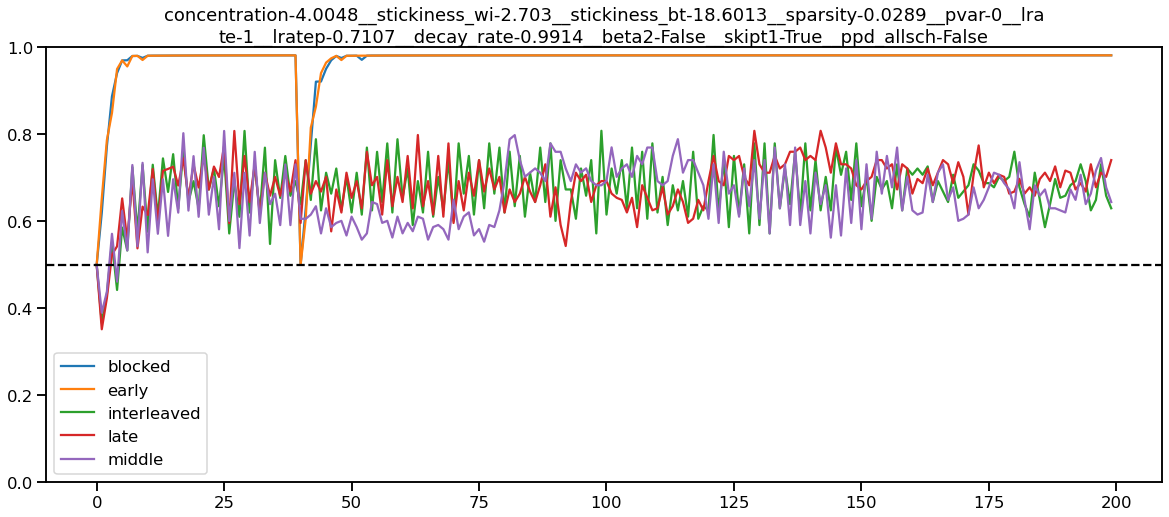

In [12]:
plt_cond_df(cond_df)

### plot full subtable

In [13]:
for idx,row in sgsdf.iterrows():
  print()
  cond_df = get_cond_df(row)
  plt_cond_df(cond_df)
  plt.close('all')


query concentration == 4.004800 and stickiness_wi == 2.703000 and stickiness_bt == 18.601300 and sparsity == 0.028900 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.710700 and decay_rate == 0.991400 and skipt1 == 1.000000
found concentration-4.0048__stickiness_wi-2.703__stickiness_bt-18.6013__sparsity-0.0289__pvar-0__lrate-1__lratep-0.7107__decay_rate-0.9914__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 4.398700 and stickiness_wi == 3.219000 and stickiness_bt == 31.890000 and sparsity == 0.024800 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.768400 and decay_rate == 0.994700 and skipt1 == 1.000000
found concentration-4.3987__stickiness_wi-3.219__stickiness_bt-31.89__sparsity-0.0248__pvar-0__lrate-1__lratep-0.7684__decay_rate-0.9947__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 2.329400 and stickiness_wi == 1.245200 and stickiness_bt == 17.306300 and sparsity == 0.011500 and pvar == 0.000000 and lrate == 1.000000 and 


query concentration == 1.057200 and stickiness_wi == 64.226100 and stickiness_bt == 87.882900 and sparsity == 0.012500 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.808400 and decay_rate == 0.999000 and skipt1 == 1.000000
found concentration-1.0572__stickiness_wi-64.2261__stickiness_bt-87.8829__sparsity-0.0125__pvar-0__lrate-1__lratep-0.8084__decay_rate-0.999__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 2.867000 and stickiness_wi == 69.675700 and stickiness_bt == 86.739500 and sparsity == 0.033400 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.979100 and decay_rate == 0.995700 and skipt1 == 1.000000
found concentration-2.867__stickiness_wi-69.6757__stickiness_bt-86.7395__sparsity-0.0334__pvar-0__lrate-1__lratep-0.9791__decay_rate-0.9957__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 3.415000 and stickiness_wi == 68.913500 and stickiness_bt == 62.491700 and sparsity == 0.040500 and pvar == 0.000000 and lrate == 1.0000


query concentration == 3.484300 and stickiness_wi == 35.596100 and stickiness_bt == 35.062600 and sparsity == 0.058400 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.873300 and decay_rate == 0.983400 and skipt1 == 1.000000
found concentration-3.4843__stickiness_wi-35.5961__stickiness_bt-35.0626__sparsity-0.0584__pvar-0__lrate-1__lratep-0.8733__decay_rate-0.9834__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 1.763800 and stickiness_wi == 79.462400 and stickiness_bt == 62.088000 and sparsity == 0.018800 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.259200 and decay_rate == 0.982200 and skipt1 == 1.000000
found concentration-1.7638__stickiness_wi-79.4624__stickiness_bt-62.088__sparsity-0.0188__pvar-0__lrate-1__lratep-0.2592__decay_rate-0.9822__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 1.774600 and stickiness_wi == 67.249900 and stickiness_bt == 57.101000 and sparsity == 0.019300 and pvar == 0.000000 and lrate == 1.000


query concentration == 1.217500 and stickiness_wi == 14.608800 and stickiness_bt == 48.755600 and sparsity == 0.032900 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.662700 and decay_rate == 0.986900 and skipt1 == 1.000000
found concentration-1.2175__stickiness_wi-14.6088__stickiness_bt-48.7556__sparsity-0.0329__pvar-0__lrate-1__lratep-0.6627__decay_rate-0.9869__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 3.226400 and stickiness_wi == 28.865300 and stickiness_bt == 83.144600 and sparsity == 0.044900 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.723800 and decay_rate == 0.965800 and skipt1 == 1.000000
found concentration-3.2264__stickiness_wi-28.8653__stickiness_bt-83.1446__sparsity-0.0449__pvar-0__lrate-1__lratep-0.7238__decay_rate-0.9658__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 2.277300 and stickiness_wi == 30.391500 and stickiness_bt == 57.178900 and sparsity == 0.040400 and pvar == 0.000000 and lrate == 1.00


query concentration == 3.539600 and stickiness_wi == 21.951000 and stickiness_bt == 43.948100 and sparsity == 0.106800 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.760500 and decay_rate == 0.986600 and skipt1 == 1.000000
found concentration-3.5396__stickiness_wi-21.951__stickiness_bt-43.9481__sparsity-0.1068__pvar-0__lrate-1__lratep-0.7605__decay_rate-0.9866__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 4.726700 and stickiness_wi == 23.562200 and stickiness_bt == 29.862000 and sparsity == 0.148300 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.699800 and decay_rate == 0.997600 and skipt1 == 1.000000
found concentration-4.7267__stickiness_wi-23.5622__stickiness_bt-29.862__sparsity-0.1483__pvar-0__lrate-1__lratep-0.6998__decay_rate-0.9976__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 3.519000 and stickiness_wi == 0.761300 and stickiness_bt == 21.865900 and sparsity == 0.089800 and pvar == 0.000000 and lrate == 1.00000


query concentration == 1.704000 and stickiness_wi == 1.664000 and stickiness_bt == 22.364400 and sparsity == 0.154400 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.758500 and decay_rate == 0.996500 and skipt1 == 1.000000
found concentration-1.704__stickiness_wi-1.664__stickiness_bt-22.3644__sparsity-0.1544__pvar-0__lrate-1__lratep-0.7585__decay_rate-0.9965__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 4.990900 and stickiness_wi == 80.508700 and stickiness_bt == 89.610700 and sparsity == 0.045600 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.656100 and decay_rate == 0.970400 and skipt1 == 1.000000
found concentration-4.9909__stickiness_wi-80.5087__stickiness_bt-89.6107__sparsity-0.0456__pvar-0__lrate-1__lratep-0.6561__decay_rate-0.9704__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 1.957000 and stickiness_wi == 81.757500 and stickiness_bt == 69.478200 and sparsity == 0.017000 and pvar == 0.000000 and lrate == 1.000000


query concentration == 0.578800 and stickiness_wi == 8.318300 and stickiness_bt == 61.905100 and sparsity == 0.021600 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.983600 and decay_rate == 0.991300 and skipt1 == 1.000000
found concentration-0.5788__stickiness_wi-8.3183__stickiness_bt-61.9051__sparsity-0.0216__pvar-0__lrate-1__lratep-0.9836__decay_rate-0.9913__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 4.420500 and stickiness_wi == 19.541900 and stickiness_bt == 93.237100 and sparsity == 0.096400 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.966300 and decay_rate == 0.974300 and skipt1 == 1.000000
found concentration-4.4205__stickiness_wi-19.5419__stickiness_bt-93.2371__sparsity-0.0964__pvar-0__lrate-1__lratep-0.9663__decay_rate-0.9743__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 4.767700 and stickiness_wi == 32.245500 and stickiness_bt == 55.301000 and sparsity == 0.083300 and pvar == 0.000000 and lrate == 1.0000


query concentration == 4.182600 and stickiness_wi == 43.643200 and stickiness_bt == 70.237800 and sparsity == 0.066600 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.931600 and decay_rate == 0.970600 and skipt1 == 1.000000
found concentration-4.1826__stickiness_wi-43.6432__stickiness_bt-70.2378__sparsity-0.0666__pvar-0__lrate-1__lratep-0.9316__decay_rate-0.9706__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 1.641900 and stickiness_wi == 23.831500 and stickiness_bt == 70.321100 and sparsity == 0.019600 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.754300 and decay_rate == 0.969300 and skipt1 == 1.000000
found concentration-1.6419__stickiness_wi-23.8315__stickiness_bt-70.3211__sparsity-0.0196__pvar-0__lrate-1__lratep-0.7543__decay_rate-0.9693__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 5.839100 and stickiness_wi == 29.951500 and stickiness_bt == 67.005100 and sparsity == 0.115900 and pvar == 0.000000 and lrate == 1.00